In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
import ipywidgets as widgets

In [4]:
from IPython.display import clear_output
import json

In [5]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
from utils.clustering import get_lda_clusters, get_vocab, word_topics_clustering, sort_meaningful, get_trf_clusters, topic_count
from utils.clustering_evaluation import get_characters_with_tv_trop_info, variation_of_information, group_labels_by_clusters

In [7]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )

In [52]:
movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)

characters_and_movies = characters.merge(movies, how='left', on='wiki_id')
characters_and_movies = characters_and_movies[characters_and_movies['revenue'] > 1e7]
characters_and_movies = characters_and_movies #[['wiki_id', 'title', 'character', 'cluster']]

In [54]:
characters_and_movies[['wiki_id', 'title', 'character', 'cluster']]

,wiki_id,title,character,cluster
0,31186339,The Hunger Games,Peeta Mellark,29
1,31186339,The Hunger Games,Cato,15
2,31186339,The Hunger Games,Katniss,9
3,31186339,The Hunger Games,Rue,1
4,31186339,The Hunger Games,Seneca Crane,14
...,...,...,...,...
74762,5454803,The Lives of Others,Anton Grubitz,48
74774,24005728,Running Turtle,seong,19
74775,24005728,Running Turtle,Gi,45
74776,24005728,Running Turtle,tae,14


In [56]:
lor_characters = characters_and_movies[characters_and_movies['title'].str.contains('Lord of the Rings')][['wiki_id', 'title', 'character', 'cluster', 'adj', 'active', 'patient']]
lor_characters

,wiki_id,title,character,cluster,adj,active,patient
25800,173941,The Lord of the Rings: The Fellowship of the Ring,Boromir,34,"[man, die]","[give, realise, try, die]",[]
25801,173941,The Lord of the Rings: The Fellowship of the Ring,Merry,11,[capture],[lead],[rescue]
25802,173941,The Lord of the Rings: The Fellowship of the Ring,Gandalf,24,[Sauron],"[catch, ride, escape, confront, fall]",[]
25803,173941,The Lord of the Rings: The Fellowship of the Ring,Frodo Baggins,9,"[nephew, Pony]","[wound, manage, escape, gaze, say]","[warn, take, inform, find, find]"
25804,173941,The Lord of the Rings: The Fellowship of the Ring,Saruman,13,[White],"[reveal, command, assemble]",[]
25805,173941,The Lord of the Rings: The Fellowship of the Ring,Sam,17,[],"[find, join, gaze]",[]
29232,396607,The Lord of the Rings,Boromir,45,[son],"[try, kill]",[]
29233,396607,The Lord of the Rings,Bilbo Baggins,41,[],"[discover, agree, argue]",[]
29234,396607,The Lord of the Rings,Gandalf,19,[wizard],"[learn, meet, argue, fall, persuade, arrive]","[meet, find]"
29235,396607,The Lord of the Rings,Sam,19,[faithful],"[insist, discover]",[]


In [19]:
topics_dict = json.load(open('data/words_by_topic.json', 'r'))
lda_components = np.load('data/lda_components.npy')
with open('topics_description.txt', 'r') as f:
    topics_names = f.read().splitlines() 

In [35]:
def topic_distribution(cluster, lda_components, topics_names):
    features = ['adjective', 'active verb', 'patient verb']

    cluster_components = lda_components[cluster]
    top_topics = np.argsort(cluster_components)[-1:-21:-1]
    topic_to_probability = {}
    for i in top_topics:
        feature = features[i // 200]
        topic_to_probability[feature + ': ' + topics_names[i % 200]] = cluster_components[i]
    return topic_to_probability

In [36]:
len(topic_distribution(0, lda_components, topics_names))

20

       wiki_id                                  title  character  cluster  \
71463   173944  The Lord of the Rings: The Two Towers    Théoden        1   
71469   173944  The Lord of the Rings: The Two Towers  Treebeard        1   

         adj              active             patient  
71463     []  [entrance, decide]  [free, warn, lead]  
71469  [old]            [refuse]              [meet]  


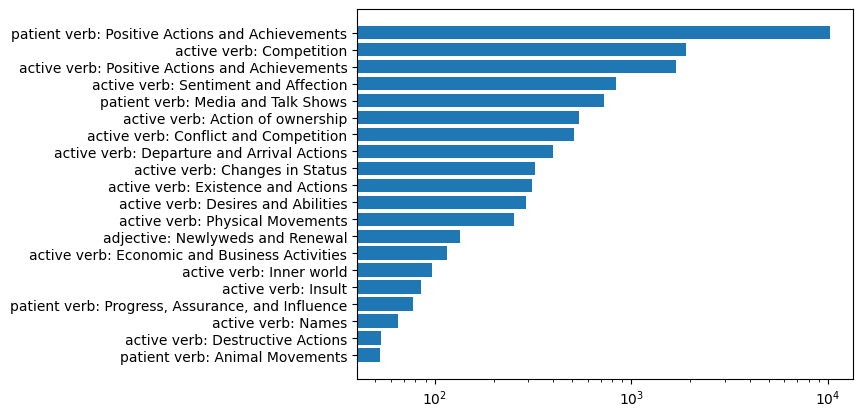

       wiki_id                                              title character  \
25800   173941  The Lord of the Rings: The Fellowship of the Ring   Boromir   

       cluster         adj                     active patient  
25800       34  [man, die]  [give, realise, try, die]      []  


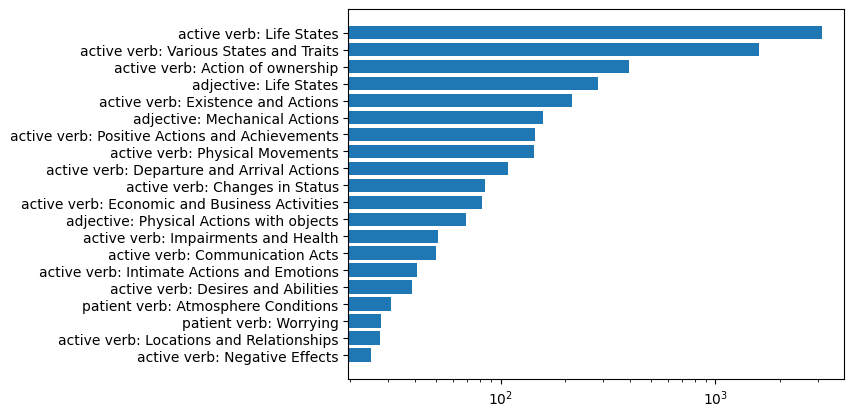

       wiki_id                                  title character  cluster adj  \
71461   173944  The Lord of the Rings: The Two Towers    Gollum        6  []   

                                active             patient  
71461  [lead, convince, struggle, vow]  [capture, despise]  


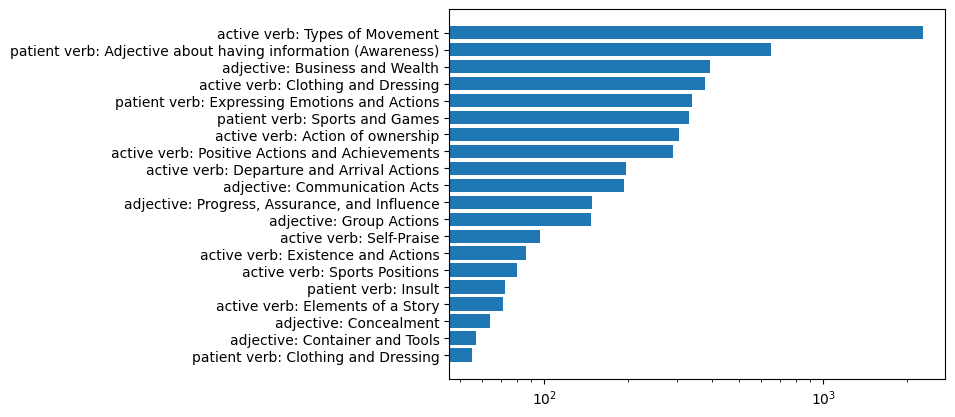

       wiki_id                                  title character  cluster  \
71466   173944  The Lord of the Rings: The Two Towers   Saruman       39   

           adj                active           patient  
71466  [White]  [dispatch, decimate]  [inform, strand]  


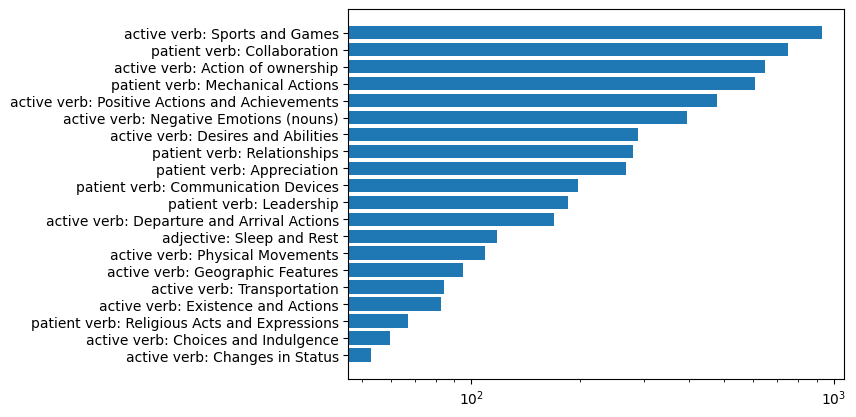

       wiki_id                                          title character  \
74185   174251  The Lord of the Rings: The Return of the King    Gollum   

       cluster adj                              active          patient  
74185       38  []  [persuade, betray, attack, attack]  [attack, leave]  


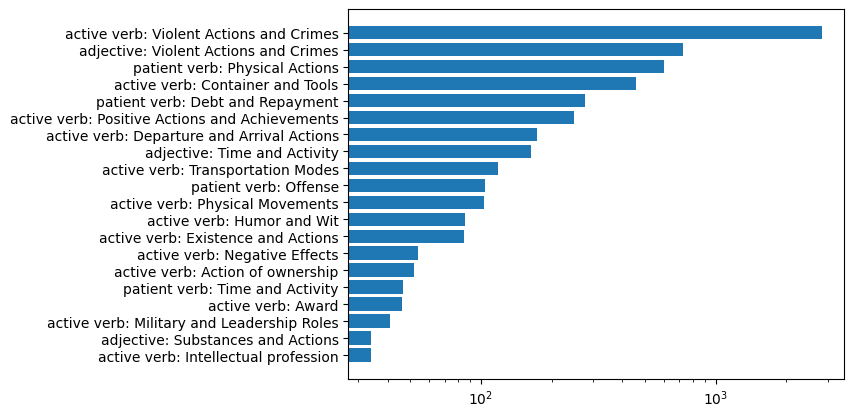

       wiki_id                                              title  \
25803   173941  The Lord of the Rings: The Fellowship of the Ring   

           character  cluster             adj  \
25803  Frodo Baggins        9  [nephew, Pony]   

                                   active                           patient  
25803  [wound, manage, escape, gaze, say]  [warn, take, inform, find, find]  


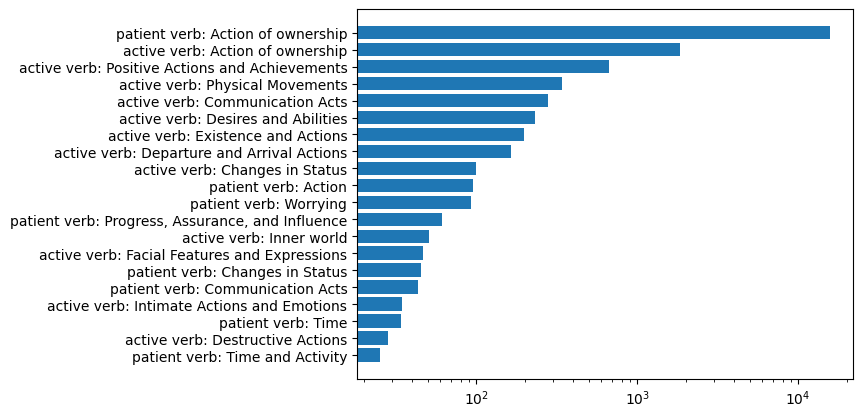

       wiki_id                  title      character  cluster adj  \
29233   396607  The Lord of the Rings  Bilbo Baggins       41  []   

                         active patient  
29233  [discover, agree, argue]      []  


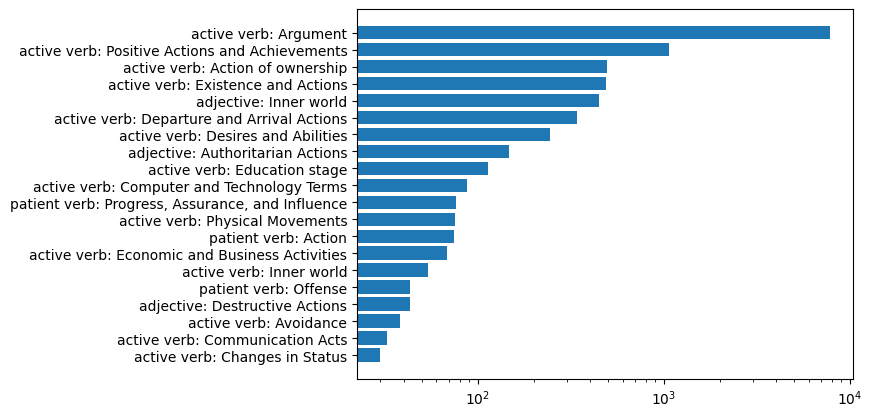

       wiki_id                                              title character  \
25801   173941  The Lord of the Rings: The Fellowship of the Ring     Merry   

       cluster        adj  active   patient  
25801       11  [capture]  [lead]  [rescue]  


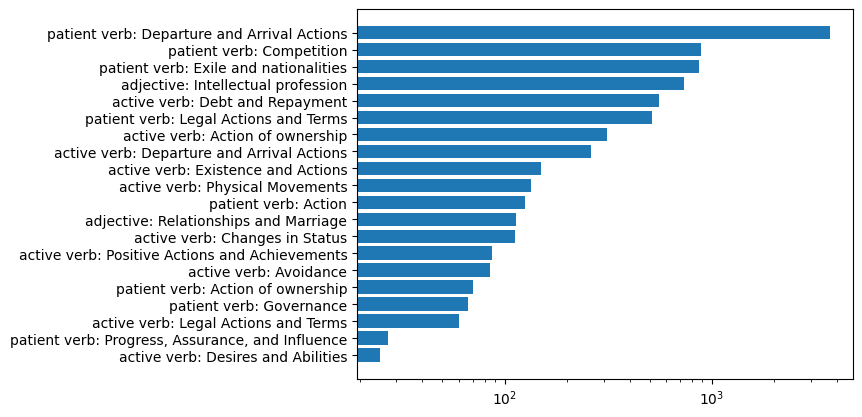

       wiki_id                                  title character  cluster  \
71460   173944  The Lord of the Rings: The Two Towers     Éomer       10   

            adj active patient  
71460  [nephew]  [set]  [find]  


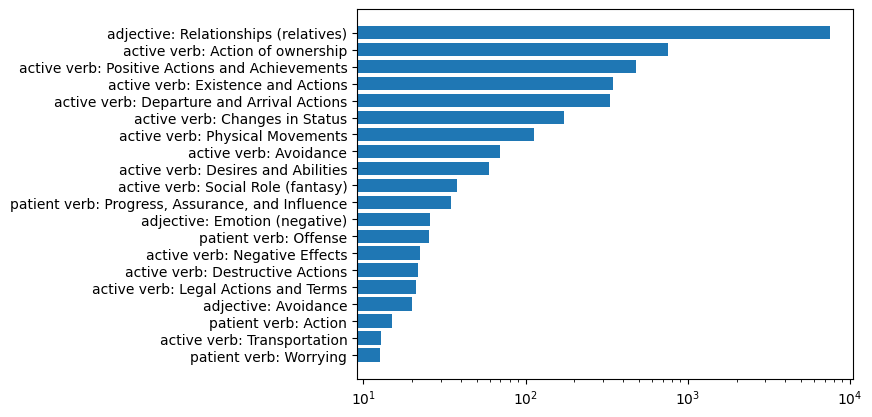

       wiki_id                                              title character  \
25804   173941  The Lord of the Rings: The Fellowship of the Ring   Saruman   

       cluster      adj                       active patient  
25804       13  [White]  [reveal, command, assemble]      []  


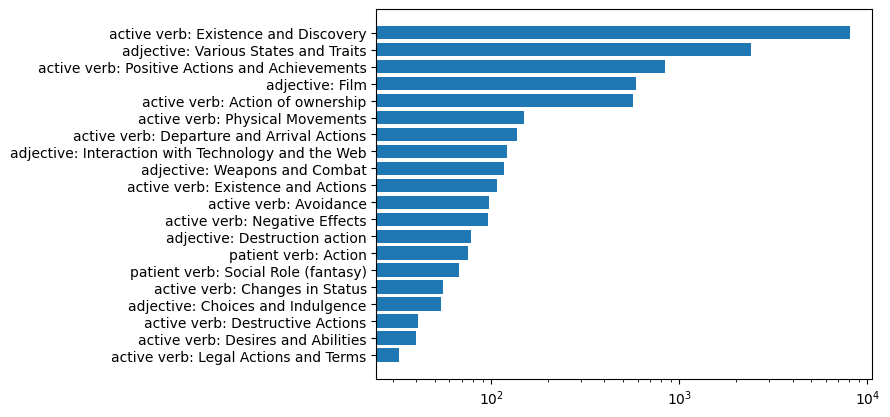

       wiki_id                                          title character  \
29232   396607                          The Lord of the Rings   Boromir   
74191   174251  The Lord of the Rings: The Return of the King    Sauron   

       cluster    adj                   active     patient  
29232       45  [son]              [try, kill]          []  
74191       45     []  [appear, plan, destroy]  [distract]  


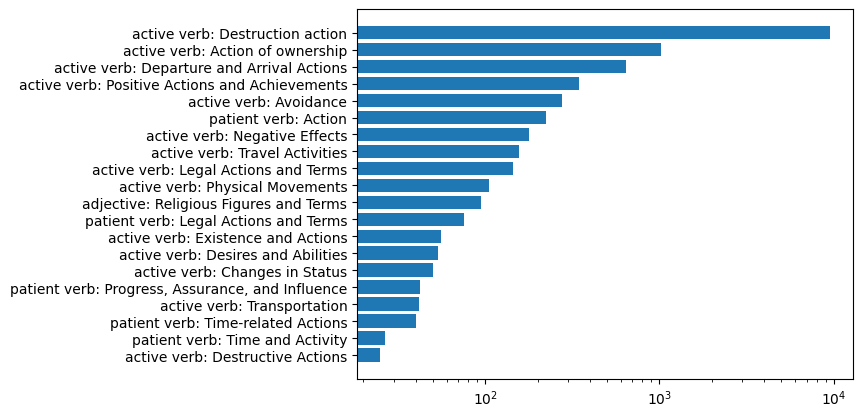

       wiki_id                                          title character  \
71462   173944          The Lord of the Rings: The Two Towers     Merry   
71468   173944          The Lord of the Rings: The Two Towers    Pippin   
74186   174251  The Lord of the Rings: The Return of the King   Théoden   

       cluster        adj        active         patient  
71462       43  [holding]        [flee]          [kill]  
71468       43         []  [flee, show]          [kill]  
74186       43         []        [ride]  [signal, kill]  


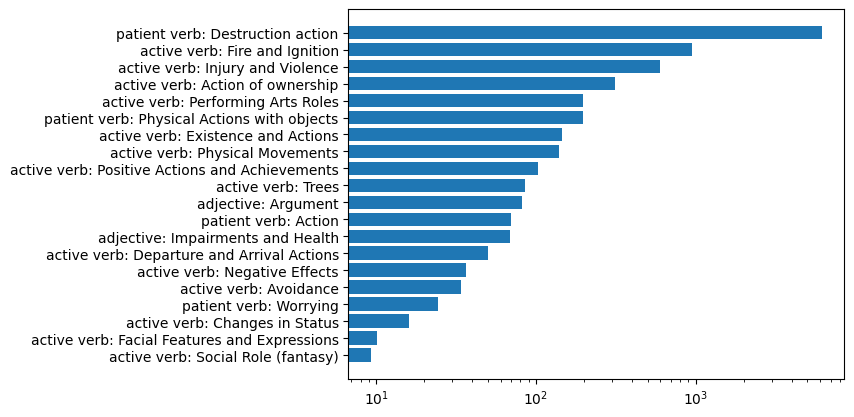

       wiki_id                                          title character  \
71464   173944          The Lord of the Rings: The Two Towers   Gandalf   
74188   174251  The Lord of the Rings: The Return of the King     Frodo   
74190   174251  The Lord of the Rings: The Return of the King    Pippin   

       cluster                adj  \
71464       12            [White]   
74188       12  [weaken, enraged]   
74190       12                 []   

                                                  active  \
71464                      [join, leave, appear, remark]   
74188  [travel, tell, enter, succumb, attack, grab, s...   
74190                         [look, tell, swear, light]   

                                                 patient  
71464                                                 []  
74188  [persuade, betray, paralyze, capture, rescue, ...  
74190                                                 []  


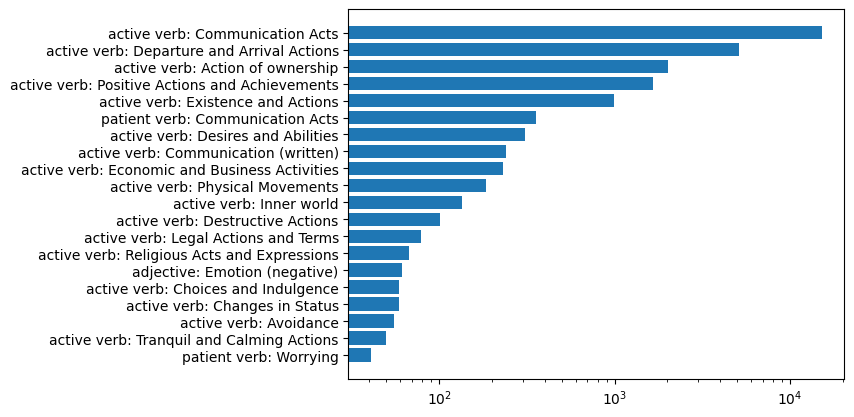

       wiki_id                                              title character  \
25805   173941  The Lord of the Rings: The Fellowship of the Ring       Sam   

       cluster adj              active patient  
25805       17  []  [find, join, gaze]      []  


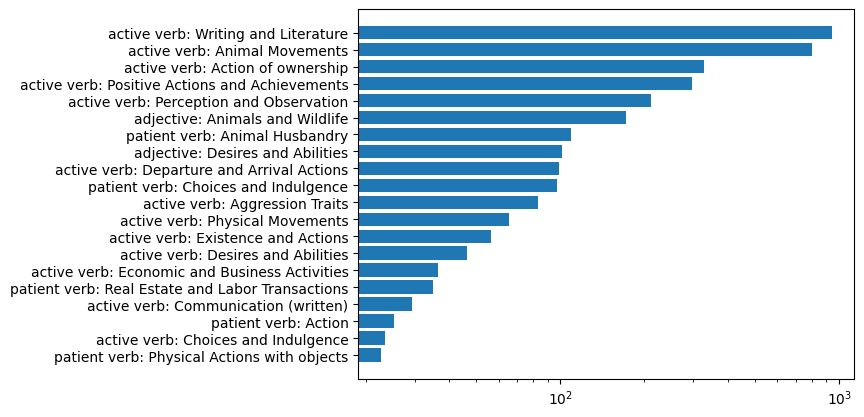

       wiki_id                                          title      character  \
71465   173944          The Lord of the Rings: The Two Towers  Frodo Baggins   
71467   173944          The Lord of the Rings: The Two Towers            Sam   
74187   174251  The Lord of the Rings: The Return of the King        Gandalf   

       cluster          adj  \
71465       42           []   
71467       42  [influence]   
74187       42           []   

                                                  active       patient  
71465  [continue, capture, take, persuade, traverse, ...  [warn, kill]  
71467      [capture, despise, traverse, capture, remind]        [kill]  
74187              [meet, deduce, ride, urge, intervene]            []  


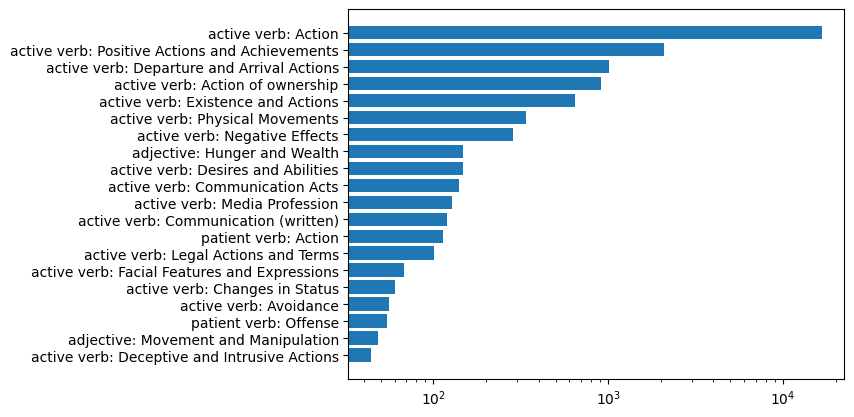

       wiki_id                  title character  cluster         adj  \
29234   396607  The Lord of the Rings   Gandalf       19    [wizard]   
29235   396607  The Lord of the Rings       Sam       19  [faithful]   
29236   396607  The Lord of the Rings    Sauron       19          []   

                                             active       patient  
29234  [learn, meet, argue, fall, persuade, arrive]  [meet, find]  
29235                            [insist, discover]            []  
29236                        [make, teach, capture]            []  


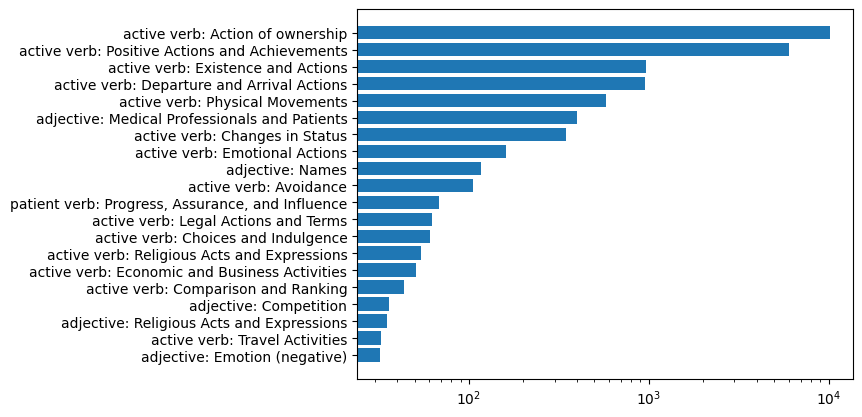

       wiki_id                                          title character  \
74189   174251  The Lord of the Rings: The Return of the King       Sam   

       cluster adj                                             active patient  
74189       20  []  [travel, overhear, want, rescue, enter, carry,...  [tell]  


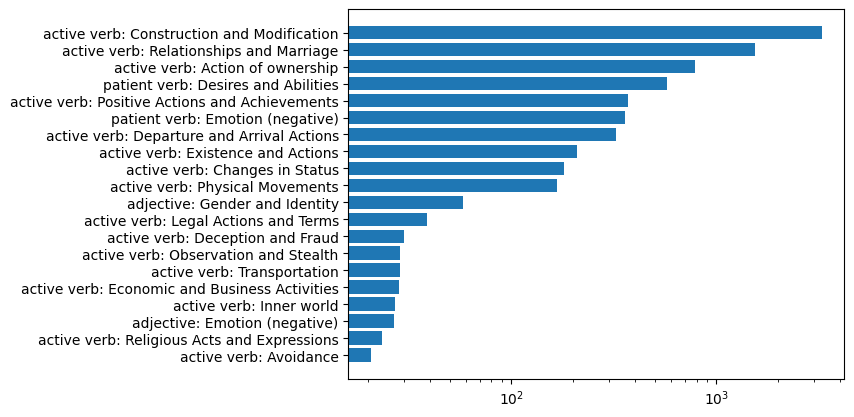

       wiki_id                                              title character  \
25802   173941  The Lord of the Rings: The Fellowship of the Ring   Gandalf   

       cluster       adj                                 active patient  
25802       24  [Sauron]  [catch, ride, escape, confront, fall]      []  


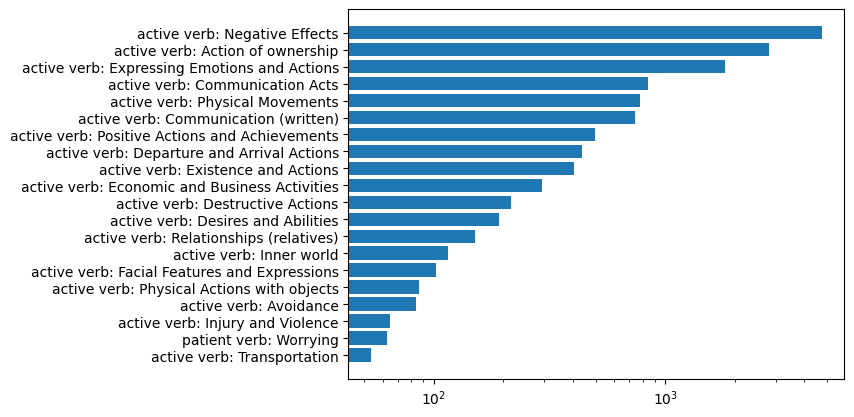

In [57]:
for i in set(lor_characters['cluster'].values):
    print(lor_characters[lor_characters['cluster']==i])
    topic_distr = topic_distribution(i, lda_components, topics_names)
    y_pos = np.arange(20)
    plt.barh(y_pos, list(topic_distr.values()))
    plt.yticks(y_pos, labels=list(topic_distr.keys()))
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.show()